# Using R to Build and Evaluate a Basic Decision Tree Model

First, we need in import the various libraries we require for our analysis.

In [3]:
library(rpart)
library(rattle)
library(rpart.plot)
library(RColorBrewer)
library(caret)
library(repr)
library(tidyverse)

options(repr.plot.width=15, repr.plot.height=15)

ERROR: Error in library(tidyverse): there is no package called ‘tidyverse’


In [4]:
## Get the data from a csv file

titanic <- read.csv("titanic.csv")

### Examine Data

You can print out the dataframe by running a codeblock with the dataframe name in it- in this case ```titanic```. You can also use the ```summary``` command to see various summary statistics.

In [5]:
## Examine dataframe

titanic

Survived,Pclass,Name,Sex,Age,Siblings.Spouses.Aboard,Parents.Children.Aboard,Fare
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
0,3,Mr. Owen Harris Braund,male,22,1,0,7.2500
1,1,Mrs. John Bradley (Florence Briggs Thayer) Cumings,female,38,1,0,71.2833
1,3,Miss. Laina Heikkinen,female,26,0,0,7.9250
1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35,1,0,53.1000
0,3,Mr. William Henry Allen,male,35,0,0,8.0500
0,3,Mr. James Moran,male,27,0,0,8.4583
0,1,Mr. Timothy J McCarthy,male,54,0,0,51.8625
0,3,Master. Gosta Leonard Palsson,male,2,3,1,21.0750
1,3,Mrs. Oscar W (Elisabeth Vilhelmina Berg) Johnson,female,27,0,2,11.1333


Looking at your data is critical before you start doing any analysis. In this specific dataset, the "Survived" column indicates whether the individual survived ("1') or prerished ("0"). So, "1" is the positive case.

In [6]:
summary(titanic)

    Survived          Pclass          Name               Sex           
 Min.   :0.0000   Min.   :1.000   Length:887         Length:887        
 1st Qu.:0.0000   1st Qu.:2.000   Class :character   Class :character  
 Median :0.0000   Median :3.000   Mode  :character   Mode  :character  
 Mean   :0.3856   Mean   :2.306                                        
 3rd Qu.:1.0000   3rd Qu.:3.000                                        
 Max.   :1.0000   Max.   :3.000                                        
      Age        Siblings.Spouses.Aboard Parents.Children.Aboard
 Min.   : 0.42   Min.   :0.0000          Min.   :0.0000         
 1st Qu.:20.25   1st Qu.:0.0000          1st Qu.:0.0000         
 Median :28.00   Median :0.0000          Median :0.0000         
 Mean   :29.47   Mean   :0.5254          Mean   :0.3833         
 3rd Qu.:38.00   3rd Qu.:1.0000          3rd Qu.:0.0000         
 Max.   :80.00   Max.   :8.0000          Max.   :6.0000         
      Fare        
 Min.   :  0.000  
 1s

### Set up Training and Testing Datasets

Now we need to take our data and start organizing it for our modeling. Remember you have to train and evaluate your model, so the first step is splitting our data into training and testing(evaluating) dataframes.

In [7]:
## 75% sample for training data
sample_size <- floor(0.75 * nrow(titanic))

If we want to be able to directly compare models, we need to make sure the random sampling is the same. We do this by setting a seed which is used to generate the random sample. Anyone who uses this same seed will get the same random sample.

In [8]:
## Use seed to make models reproduceable
set.seed(123)

## Determine the row numbers to sample
train_split <- sample(seq_len(nrow(titanic)), size = sample_size)

The following code block takes our original dataframe and separates it into training and testing datasets based on the sample size we set earlier.

In [9]:
## Split the data into 75% training and 25% testing
train <- titanic[train_split, ]
test <- titanic[-train_split, ]

## Validate that the dataframes are correct

cat("There are ", nrow(train), " rows in the training data. \n")
cat("There are ", nrow(test), " rows in the testing data.")

There are  665  rows in the training data. 
There are  222  rows in the testing data.

### Use the Training Dataset to Build the Model

We are going to use the R library called rpart to create our decision tree. You can read more about it here: http://www.milbo.org/doc/prp.pdf

In R, there is a standard way to create the model that uses an equation format similar to a standard linear equation. On the left is the predicted or dependent variable, ```~``` indicates the equal sign, and each independent variable is to the right of this sign.

```R
predicted_variable ~ independent_variable_1 + independent_variable_2
```



In [20]:
## Build a decision tree model
my_tree <- rpart(Survived ~ Pclass + Sex + Age + Siblings.Spouses.Aboard + Parents.Children.Aboard + Fare, data = train, method = "class", cp =.01)

### Plot the Decision Tree

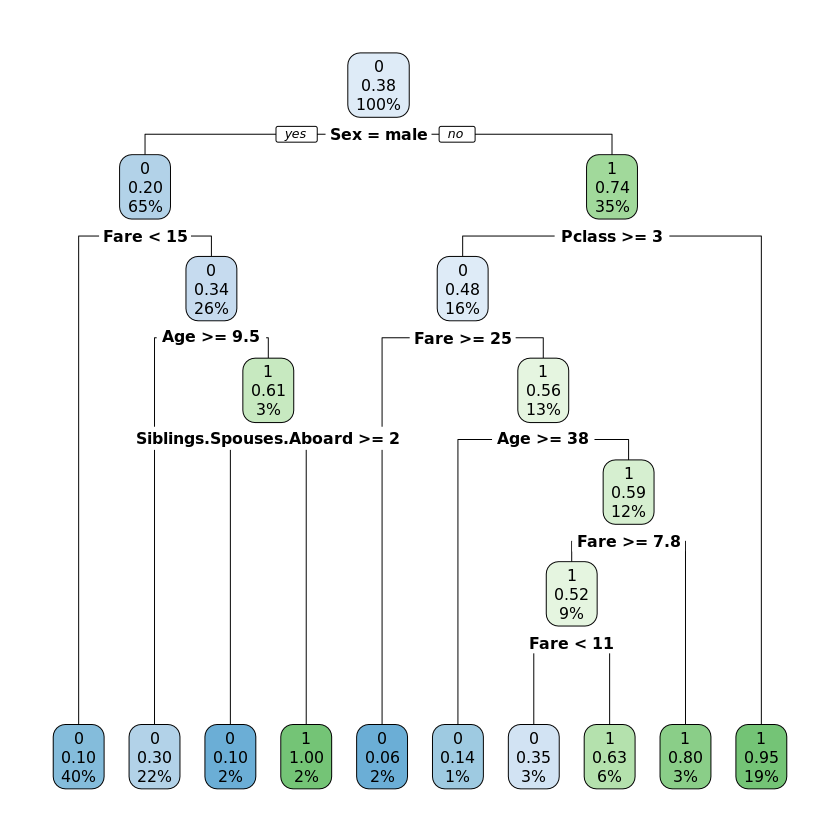

In [21]:
## Plot the model results
rpart.plot(my_tree)

### Examine the Rules from our Tree Model

The ```rpart``` library also has a way to print out a table that defines all the rules for the generated model. After you run the code below, the table will give you the probability in the 'Survived" column and the rules. This rules table represents the end nodes in the model.

In [22]:
rpart.rules(my_tree, cover=TRUE)

,Survived,,.1,.2,.3,.4,.5,.6,.7,.8,⋯,,.1,.2,.3,.4,.5,.6,.7,.8,cover
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
12,0.06,when,Sex,is,female,&,Fare,>=,,,⋯,,&,Pclass,>=,3,,,,,2%
22,0.10,when,Sex,is,male,&,Fare,>=,,,⋯,9.5,,,,,&,Siblings.Spouses.Aboard,>=,2,2%
4,0.10,when,Sex,is,male,&,Fare,<,15.2,,⋯,,,,,,,,,,40%
26,0.14,when,Sex,is,female,&,Fare,<,24.8,,⋯,38.0,&,Pclass,>=,3,,,,,1%
10,0.30,when,Sex,is,male,&,Fare,>=,,,⋯,9.5,,,,,,,,,22%
108,0.35,when,Sex,is,female,&,Fare,is,7.8,to,⋯,38.0,&,Pclass,>=,3,,,,,3%
109,0.63,when,Sex,is,female,&,Fare,is,10.8,to,⋯,38.0,&,Pclass,>=,3,,,,,6%
55,0.80,when,Sex,is,female,&,Fare,<,7.8,,⋯,38.0,&,Pclass,>=,3,,,,,3%
7,0.95,when,Sex,is,female,,,,,,⋯,,&,Pclass,<,3,,,,,19%


### Evaluate the Model

Finally, we need to evaluate how well our model performed using the testing data (we can also call this the holdout data). Do do this we use our model to predict the test data outcomes. Given we already know the outcomes, we compare the predictions to the actual outcomes. We use the confusion matrix to graphically represent the different types of errors our model may have.

In [13]:
## Create the probabilities for each test data point
predict_probs <- as.data.frame(predict(my_tree, newdata = test, type = "p"))

## Create the predicted test values and ground truth values and .5 threshold value
predicted <- as.integer(predict_probs$`1` > .5)
actual <- test$Survived

## Build confusion matrix
confusionMatrix(as.factor(predicted), as.factor(actual), positive = "1")

## https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 128  31
         1   8  55
                                         
               Accuracy : 0.8243         
                 95% CI : (0.7678, 0.872)
    No Information Rate : 0.6126         
    P-Value [Acc > NIR] : 6.659e-12      
                                         
                  Kappa : 0.6107         
                                         
 Mcnemar's Test P-Value : 0.000427       
                                         
            Sensitivity : 0.6395         
            Specificity : 0.9412         
         Pos Pred Value : 0.8730         
         Neg Pred Value : 0.8050         
             Prevalence : 0.3874         
         Detection Rate : 0.2477         
   Detection Prevalence : 0.2838         
      Balanced Accuracy : 0.7904         
                                         
       'Positive' Class : 1              
                                         